# Reactive 1-D Flow in a Pipe
Tom Kovar

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

## Background
As a chemical engineer, I am oftentimes interested in reactive flow systems.  Typical systems of interest incude continuously stirred tank reactors (CSTRs), plug flow reactors (PFRs), packed bed reactors (PBRs) and fluidized bed reactors. While the equations governing CSTRs are too simple and the equations governing fluidized bed reactors are too complex for the scope of this course, the equations to model an unsteady plug flow reactor are an appropriate level to look at.  In this project we will derive the equations governing this as well as utilize tools from this course to write a numerical solver. Finally we will use other tools from this course to see if we can improve the solver.  

## System
For this project we are looking at a long pipe of incompressible fluid which initially has no species A.  A fluid then flows into the pipe at velocity $\bar{u}$ and with concentration $C_{Ao}$. For this problem we will assume the first order, irreversible reaction as shown below.

$$
A \: -> B
$$

We also assume that this reaction has a rate constant $\alpha$.  Below, we will derive the equations which govern this system.

## Derivation of Equations

As I am a chemical engineering, I would like to derive the equations governing this system in a way we often see in transport phenonena. We will begin with a cubic control volume of size $\Delta x \Delta y \Delta z$. We can then do a material balance on species A in the control volume assuming the equation, <br>
Accumulation= in - out + generation - constumption
This equation becomes,
$$
V_{control} \frac{\partial {C_{A}}}{\partial {t}}=u_x C_A |_{x}\Delta y \Delta z+u_y C_A |_{y}\Delta x \Delta z + u_z C_A |_{z}\Delta x \Delta y-u_x C_A |_{x+\Delta x}\Delta y \Delta z-u_y C_A |_{y+\Delta y}\Delta x \Delta z - u_z C_A |_{z+\Delta z}\Delta x \Delta y - \alpha C_A
$$

In the equation above, the first three terms on the right hand side (RHS) of the equation are the flux of species A into the control volume while, terms 4-6 on the RHS of the equation are flux of species A out of the control volume. The final term is the consumption of species A due to reaction. Note, for this model, we are assuming that species A is transported into the conrol volume by convection only and that diffusion is negligible in comparison.  This is true at very large Re which is required for plug flow.  Rearranging the equation and utilizing $V_{control}=\Delta x \Delta y \Delta z$ we get,

$$
\frac{\partial {C_{A}}}{\partial {t}}= u_x \frac{C_A |_{x}-C_A |_{x+\Delta x}}{\Delta x}+u_y \frac{C_A |_{y}-C_A |_{y+\Delta y}}{\Delta y}+u_z \frac{C_A |_{z}-C_A |_{z+\Delta z}}{\Delta z}-\alpha C_A
$$

If we take the limit as $\Delta x$, $\Delta y$, and $\Delta z$ all go to zero we see that terms on the RHS of the equation are the definition of the negative derivative and the equation becomes,

$$
\frac{\partial {C_{A}}}{\partial {t}}=-\alpha C_A-u \cdot \nabla C_A
$$

The same can be done for species B. However, now B is being generated rather than consumed at a rate proportional to $C_A$ so we get,

$$
\frac{\partial {C_{B}}}{\partial {t}}=\alpha C_A-u\cdot \nabla C_B
$$

Finally, for the most simple case, we will assume unidirectional flow, yielding the final equations,

$$
\frac{\partial {C_{A}}}{\partial {t}} + u_x \frac{\partial {C_{A}}}{\partial {x}}=-\alpha C_A \\
\frac{\partial {C_{B}}}{\partial {t}} + u_x \frac{\partial {C_{B}}}{\partial {x}}=\alpha C_A
$$

or in matrix notations,

$$
q_t+Aq_x=-\beta q
$$

Where,

$$
q=\begin{bmatrix} C_A \\ C_B\end{bmatrix} \: A=\begin{bmatrix} u_x & 0 \\  0 & u_x \end{bmatrix} \: \beta=\begin{bmatrix} \alpha & 0 \\ -\alpha & 0 \end{bmatrix}
$$

## The Solver
Prior to writing the solver we want to choose our grid wisely.  First, we want to make sure that the CFL condition is satisfied as shown below.

$$
\begin{vmatrix}\frac{\bar{u}\Delta t}{\Delta x}\end{vmatrix} \leq 1 
$$

For our system, we will assume a 100 meter long pipe with 1000 grid cells such that $\Delta x = 0.1 m$. We will also assume a $u_x$ of 1 m/s. This requires $\Delta t$ be less than 0.1 s. I also want to pick an $\alpha$ value such that the species A is at least half reacted before reaching the end of the pipe. To do this we can solve the equation below.
$$
\frac{dC_A}{dt}=-\alpha C_A
$$

Separating and integrating we get,

$$
\int_{C_{Ao}}^{0.5C_{Ao}} dC_A=\int_0^t -\alpha dt \\
ln(0.5)=-\alpha t
$$

We know it takes 100 s for the fluid to go from one end of the pipe to the other. Using 100 seconds we get and $\alpha$ value of 0.0069 $s^{-1}$.  We will therefore assume an $\alpha$ value of 0.01 $s^{-1}$. Additionally, we will assume that the inlet concentration of species A is 0.5 $kg/m^3$ and 0 $kg/m^3$ in the pipe at t=0. Finally, we will assume the concentration of species B is 0 $kg/m^3$ in both the inlet and pipe at t=0.  A summary of the boundary and initial conditions can be seen below.

$$
q(0,t)=\begin{bmatrix}0.5 \\0 \end{bmatrix} \: q(x,0)=\begin{bmatrix} \begin{cases} 0.5 \: x\leq 0 \\ 0 \: x > 0 \end{cases} \\0 \end{bmatrix}
$$

For this system, we notice that this equation is the advection equation with a source term.  Meaning that the flux through the left edge of a cell is determined entirely by $Q_{i-1}^n$. This leads us to utilize the first order upwind method shown below.

$$
Q_i^{n+1}=Q_i^n-(A \frac{Q_i^n-Q_{i-1}^n}{\Delta x}+\beta Q_i^n)\Delta t
$$
For simplicity of coding, we will split these into two equations as shown below.

$$
C_{A_i}^{n+1}=C_{A_i}^n-(u_x \frac{C_{A_i}^n-C_{A_{i-1}}^n}{\Delta x}+\alpha C_{A_i}^n)\Delta t \\
C_{B_i}^{n+1}=C_{B_i}^n-(u_x \frac{C_{B_i}^n-C_{B_{i-1}}^n}{\Delta x}-\alpha C_{A_i}^n)\Delta t
$$

Below you can find the numerical solver for this system utilizing the equations above.

In [2]:
Ux=1 # m/s
nt=15000#number of time steps
L=100
dx=0.1 #length of grid cell (m)
nx=int(L/dx)#number of grid cells
x=np.linspace(0,100,nx)

dt=0.01 # length of time stem (s)
alpha=0.01 #rate constant (1/s)
Ca=np.zeros((nt,nx))
Cb=np.zeros((nt,nx))
Ca[:,0]=0.5
for t in range(nt-1):
    for i in range(1,nx-2):
    
        Ca[t+1,i]=Ca[t,i]-((Ux*Ca[t,i]-Ux*Ca[t,i-1])/dx+alpha*Ca[t,i])*dt
        Cb[t+1,i]=Cb[t,i]-((Ux*Cb[t,i]-Ux*Cb[t,i-1])/dx-alpha*Ca[t,i])*dt

To see the numerical solution as an animation. Please run the code below

In [3]:
def animation():
    fig, ax=plt.subplots(1,figsize=(12,6))
    x=np.linspace(0,100,nx)
    ax.set_xlim((0,100))
    ax.set_ylim((0,0.5))
    


    def init():
        Ca_plot,=ax.plot(x,Ca[0,:],label=f'$C_A$')
        Cb_plot,=ax.plot(x,Cb[0,:],label=f'$C_B$')
        ax.set_xlim((0,100))
        ax.set_ylim((0,0.5))
        ax.set_xlabel('Length (m)')
        ax.set_ylabel(f'C $(kg/m^3)$')
        ax.legend((f'$C_A$',f'$C_B$'))
        return  (Ca_plot,Cb_plot)
    Ca_plot,Cb_plot=init()

    def animate(t):
        Ca_plot.set_data(x,Ca[t,:])
        Cb_plot.set_data(x,Cb[t,:])
        return (Ca_plot,Cb_plot)

    steps=range(0,14000,1000)
    
    plt.close(fig)
    return FuncAnimation(fig,animate,frames=steps,init_func=init,interval=200,blit=True, repeat=False)
HTML(animation().to_jshtml())

Additionally, to see the results as concentration profiles at discrete time points, run the code below.

(0, 99)

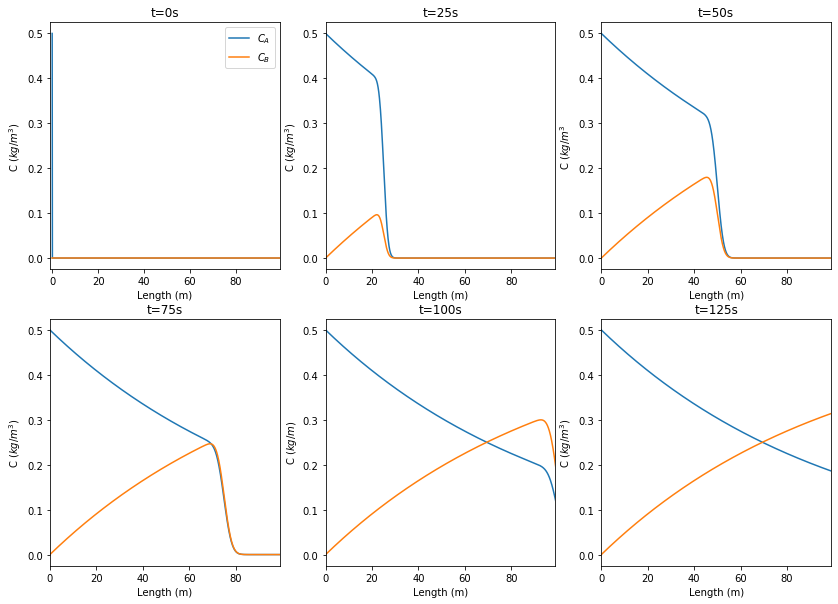

In [4]:
fig, ax=plt.subplots(ncols=3, nrows=2,figsize=(14,10))

ax[0,0].plot(x,Ca[0,:],label=f'$C_A$')
ax[0,0].plot(x,Cb[0,:],label=f'$C_B$')
ax[0,0].set_title('t=0s')
ax[0,0].set_xlabel('Length (m)')
ax[0,0].set_ylabel(f'C $(kg/m^3)$')
ax[0,0].set_xlim((-1,99))
ax[0,0].legend()

ax[0,1].plot(x,Ca[2500,:])
ax[0,1].plot(x,Cb[2500,:])
ax[0,1].set_title('t=25s')
ax[0,1].set_xlabel('Length (m)')
ax[0,1].set_ylabel(f'C $(kg/m^3)$')
ax[0,1].set_xlim((0,99))

ax[0,2].plot(x,Ca[5000,:])
ax[0,2].plot(x,Cb[5000,:])
ax[0,2].set_title('t=50s')
ax[0,2].set_xlabel('Length (m)')
ax[0,2].set_ylabel(f'C $(kg/m^3$')
ax[0,2].set_xlim((0,99))

ax[1,0].plot(x,Ca[7500,:])
ax[1,0].plot(x,Cb[7500,:])
ax[1,0].set_title('t=75s')
ax[1,0].set_xlabel('Length (m)')
ax[1,0].set_ylabel(f'C $(kg/m^3)$')
ax[1,0].set_xlim((0,99))

ax[1,1].plot(x,Ca[10000,:])
ax[1,1].plot(x,Cb[10000,:])
ax[1,1].set_title('t=100s')
ax[1,1].set_xlabel('Length (m)')
ax[1,1].set_ylabel(f'C $(kg/m)$')
ax[1,1].set_xlim((0,99))

ax[1,2].plot(x,Ca[12500,:])
ax[1,2].plot(x,Cb[12500,:])
ax[1,2].set_title('t=125s')
ax[1,2].set_xlabel('Length (m)')
ax[1,2].set_ylabel(f'C $(kg/m^3)$')
ax[1,2].set_xlim((0,99))




Luckily, this PDE is simple enough that we can compare it to the analytical solution. Using the method of characteristics, it can be shown that the system of PDEs has solutions,
$$
C_A(x,t)=C_A(x-u_x t,0)e^{-\alpha \frac{x}{u_x}}
$$

Below is the code for the analytical solution.

In [5]:
Ca_a=np.zeros((nt,nx))
Cb_a=np.zeros((nt,nx))
Ca_a[:,0]=0.5
for t in range(nt-1):
    for i in range(1,nx-2):
        if i*dx/Ux-t*dt>0:
            Ca_a[t,i]=0
            Cb_a[t,i]=0
        else:
            Ca_a[t,i]=np.exp(-alpha*(i*dx/Ux))*0.5
            Cb_a[t,i]=0.5-np.exp(-alpha*(i*dx/Ux))*0.5


To see the numerical solution plotted against the analytical solutions, run the code below.

(0, 99)

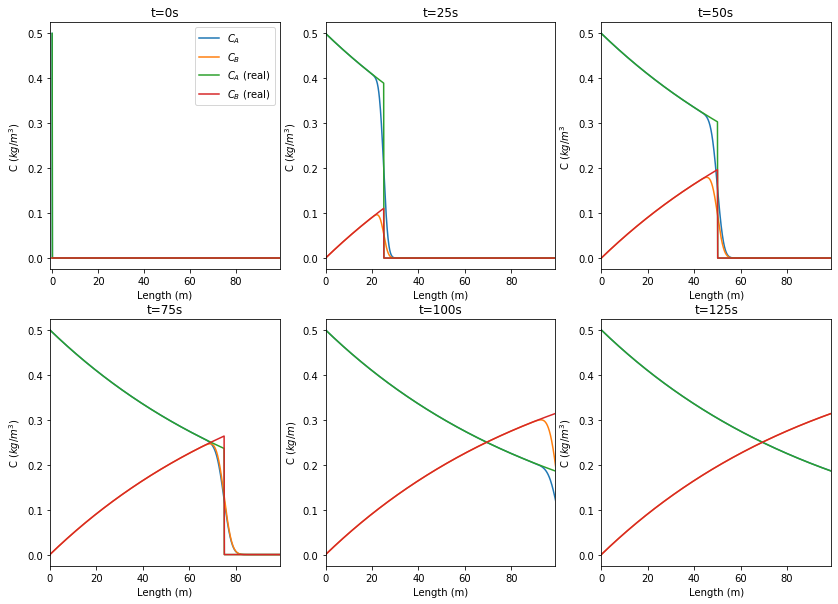

In [6]:
fig, ax=plt.subplots(ncols=3, nrows=2,figsize=(14,10))

ax[0,0].plot(x,Ca[0,:],label=f'$C_A$')
ax[0,0].plot(x,Cb[0,:],label=f'$C_B$')
ax[0,0].plot(x,Ca_a[0,:],label=f'$C_A$ (real)')
ax[0,0].plot(x,Cb_a[0,:],label=f'$C_B$ (real)')
ax[0,0].set_title('t=0s')
ax[0,0].set_xlabel('Length (m)')
ax[0,0].set_ylabel(f'C $(kg/m^3)$')
ax[0,0].set_xlim((-1,99))
ax[0,0].legend()

ax[0,1].plot(x,Ca[2500,:])
ax[0,1].plot(x,Cb[2500,:])
ax[0,1].plot(x,Ca_a[2500,:])
ax[0,1].plot(x,Cb_a[2500,:])
ax[0,1].set_title('t=25s')
ax[0,1].set_xlabel('Length (m)')
ax[0,1].set_ylabel(f'C $(kg/m^3)$')
ax[0,1].set_xlim((0,99))

ax[0,2].plot(x,Ca[5000,:])
ax[0,2].plot(x,Cb[5000,:])
ax[0,2].plot(x,Ca_a[5000,:])
ax[0,2].plot(x,Cb_a[5000,:])
ax[0,2].set_title('t=50s')
ax[0,2].set_xlabel('Length (m)')
ax[0,2].set_ylabel(f'C $(kg/m^3$')
ax[0,2].set_xlim((0,99))

ax[1,0].plot(x,Ca[7500,:])
ax[1,0].plot(x,Cb[7500,:])
ax[1,0].plot(x,Ca_a[7500,:])
ax[1,0].plot(x,Cb_a[7500,:])
ax[1,0].set_title('t=75s')
ax[1,0].set_xlabel('Length (m)')
ax[1,0].set_ylabel(f'C $(kg/m^3)$')
ax[1,0].set_xlim((0,99))

ax[1,1].plot(x,Ca[10000,:])
ax[1,1].plot(x,Cb[10000,:])
ax[1,1].plot(x,Ca_a[10000,:])
ax[1,1].plot(x,Cb_a[10000,:])
ax[1,1].set_title('t=100s')
ax[1,1].set_xlabel('Length (m)')
ax[1,1].set_ylabel(f'C $(kg/m)$')
ax[1,1].set_xlim((0,99))

ax[1,2].plot(x,Ca[12500,:])
ax[1,2].plot(x,Cb[12500,:])
ax[1,2].plot(x,Ca_a[12500,:])
ax[1,2].plot(x,Cb_a[12500,:])
ax[1,2].set_title('t=125s')
ax[1,2].set_xlabel('Length (m)')
ax[1,2].set_ylabel(f'C $(kg/m^3)$')
ax[1,2].set_xlim((0,99))


We can see from the figure above, the first order accurate solver does a decent job capturing the true mathematics of the system and that the major discrepency occurs near the discontinuity where we see numerical diffusion. In attempts to mitigate this issue.  We will look at the effects of utilizing a flux limiter on this system. 

## Flux Limiter
For this specific equation, the flux-limiter method takes the form,

$$
Q_i^{n+1}=Q_i^n-\nu(Q_i^n-Q_{i-1}^n)-\frac{1}{2}\nu(1-\nu)[\phi(\theta_{i+\frac{1}{2}}^n)(Q_{i+1}^n-Q_i^n)-\phi(\theta_{i-\frac{1}{2}}^n)(Q_{i}^n-Q_{i-1}^n)]-\beta Q_i^n \Delta t
$$

where,

$$
\nu=\frac{u_x \Delta t}{\Delta x} \\
\theta_{i-\frac{1}{2}}^n=\frac{\Delta Q_{I-\frac{1}{2}}^n}{\Delta Q_{i-\frac{1}{2}}^n}
$$

where,

$$
I = \begin{cases} i-1 \: if \: u_x>0 \\ i+1 \: if \: u_x <0 \end{cases} \\
\Delta Q_{i-\frac{1}{2}}^n=Q_i^n-Q_{i-1}^n
$$

For this project, we will use the Superbee limiter where,

$$
\phi(\theta)=max(0,min(1,2\theta),min(2,\theta))
$$

Below is the script where we update the numerical solver with the addition of the Superbee Limiter.

In [ ]:

Ux=1 # m/s
nt=15000#number of time steps
L=100
dx=0.1 #length of grid cell (m)
nx=int(L/dx)#number of grid cells
x=np.linspace(0,100,nx)

dt=0.01 # length of time stem (s)
alpha=0.01 #rate constant (1/s)
Ca_s=np.zeros((nt,nx))
Cb_s=np.zeros((nt,nx))
Ca_s[:,0]=0.5

#r=np.zeros((1,nx))
for t in range(nt-1):
    for i in range(1,nx-2):
        if i==1:
            r_i=(Ca_s[t,i]-Ca_s[t,i-1])/(Ca_s[t,i+1]-Ca_s[t,i])
            r_i_1=(Ca_s[t,i-1]-0.5)/(Ca_s[t,i]-Ca_s[t,i-1])
        
        else:
            r_i=(Ca_s[t,i]-Ca_s[t,i-1])/(Ca_s[t,i+1]-Ca_s[t,i])
            r_i_1=(Ca_s[t,i-1]-Ca_s[t,i-2])/(Ca_s[t,i]-Ca_s[t,i-1])
 
        phi_i=max([0,min([2*r_i,1]),min([r_i,2])])
        phi_i_1=max([0,min([2*r_i_1,1]),min([r_i_1,2])])
        
        Ca_s[t+1,i]=Ca_s[t,i]-Ux*dt/dx*(Ca_s[t,i]-Ca_s[t,i-1])-0.5*Ux*dt/dx*(1-Ux*dt/dx)*(phi_i*(Ca_s[t,i+1]-Ca_s[t,i])-phi_i_1*(Ca_s[t,i]-Ca_s[t,i-1]))-alpha*Ca_s[t,i]*dt
        Cb_s[t+1,i]=Cb_s[t,i]-Ux*dt/dx*(Cb_s[t,i]-Cb_s[t,i-1])-0.5*Ux*dt/dx*(1-Ux*dt/dx)*(phi_i*(Cb_s[t,i+1]-Cb_s[t,i])-phi_i_1*(Cb_s[t,i]-Cb_s[t,i-1]))+alpha*Ca_s[t,i]*dt
        

/Users/thomaskovar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thomaskovar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/thomaskovar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thomaskovar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/Users/thomaskovar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


Below we can compare the addition of the superbee limiter versus the analytical solution.

In [ ]:
fig, ax=plt.subplots(ncols=3, nrows=2,figsize=(14,10))

ax[0,0].plot(x,Ca_s[0,:],label=f'$C_A (Superbee)$')
ax[0,0].plot(x,Cb_s[0,:],label=f'$C_B (Superbee)$')
ax[0,0].plot(x,Ca_a[0,:],label=f'$C_A$ (real)')
ax[0,0].plot(x,Cb_a[0,:],label=f'$C_B$ (real)')
ax[0,0].set_title('t=0s')
ax[0,0].set_xlabel('Length (m)')
ax[0,0].set_ylabel(f'C $(kg/m^3)$')
ax[0,0].set_xlim((-1,99))
ax[0,0].legend()

ax[0,1].plot(x,Ca_s[2500,:])
ax[0,1].plot(x,Cb_s[2500,:])
ax[0,1].plot(x,Ca_a[2500,:])
ax[0,1].plot(x,Cb_a[2500,:])
ax[0,1].set_title('t=25s')
ax[0,1].set_xlabel('Length (m)')
ax[0,1].set_ylabel(f'C $(kg/m^3)$')
ax[0,1].set_xlim((0,99))

ax[0,2].plot(x,Ca_s[5000,:])
ax[0,2].plot(x,Cb_s[5000,:])
ax[0,2].plot(x,Ca_a[5000,:])
ax[0,2].plot(x,Cb_a[5000,:])
ax[0,2].set_title('t=50s')
ax[0,2].set_xlabel('Length (m)')
ax[0,2].set_ylabel(f'C $(kg/m^3$')
ax[0,2].set_xlim((0,99))

ax[1,0].plot(x,Ca_s[7500,:])
ax[1,0].plot(x,Cb_s[7500,:])
ax[1,0].plot(x,Ca_a[7500,:])
ax[1,0].plot(x,Cb_a[7500,:])
ax[1,0].set_title('t=75s')
ax[1,0].set_xlabel('Length (m)')
ax[1,0].set_ylabel(f'C $(kg/m^3)$')
ax[1,0].set_xlim((0,99))

ax[1,1].plot(x,Ca_s[10000,:])
ax[1,1].plot(x,Cb_s[10000,:])
ax[1,1].plot(x,Ca_a[10000,:])
ax[1,1].plot(x,Cb_a[10000,:])
ax[1,1].set_title('t=100s')
ax[1,1].set_xlabel('Length (m)')
ax[1,1].set_ylabel(f'C $(kg/m)$')
ax[1,1].set_xlim((0,99))

ax[1,2].plot(x,Ca_s[12500,:])
ax[1,2].plot(x,Cb_s[12500,:])
ax[1,2].plot(x,Ca_a[12500,:])
ax[1,2].plot(x,Cb_a[12500,:])
ax[1,2].set_title('t=125s')
ax[1,2].set_xlabel('Length (m)')
ax[1,2].set_ylabel(f'C $(kg/m^3)$')
ax[1,2].set_xlim((0,99))


We can see from the plots above that the superbee flux limiter helps improve the numerical solutions at the discontinuity.  However, we see a slight oscillation in concentration upstream of the discontinuity, this is one drawback we run into when deciding whether to include this limiter or not. Below is an animation of all three solutions

In [ ]:
def animation():
    fig, ax=plt.subplots(3,figsize=(12,6))
    x=np.linspace(0,100,nx)
    ax[0].set_xlim((0,100))
    ax[0].set_ylim((0,0.5))
    ax[1].set_xlim((0,100))
    ax[1].set_ylim((0,0.5))
    ax[2].set_xlim((0,100))
    ax[2].set_ylim((0,0.5))
    


    def init():
        Ca_plot,=ax[0].plot(x,Ca[0,:],label=f'$C_A$')
        Cb_plot,=ax[0].plot(x,Cb[0,:],label=f'$C_B$')
        Ca_s_plot,=ax[1].plot(x,Ca_s[0,:])
        Cb_s_plot,=ax[1].plot(x,Cb_s[0,:])
        Ca_a_plot,=ax[2].plot(x,Ca_a[0,:])
        Cb_a_plot,=ax[2].plot(x,Cb_a[0,:])
        ax[0].set_xlim((0,100))
        ax[0].set_ylim((0,0.5))
        ax[1].set_xlim((0,100))
        ax[1].set_ylim((0,0.5))
        ax[2].set_xlim((0,100))
        ax[2].set_ylim((0,0.5))
        
        
        
        ax[2].set_xlabel('Length (m)')
        ax[0].set_ylabel(f'C $(kg/m^3)$')
        ax[1].set_ylabel(f'C $(kg/m^3)$')
        ax[2].set_ylabel(f'C $(kg/m^3)$')
        
        ax[0].set_title('Upwind')
        ax[1].set_title('Superbee')
        ax[2].set_title('Real')
        
        ax[0].legend((f'$C_A$',f'$C_B$'))
        return  (Ca_plot,Cb_plot,Ca_s_plot,Cb_s_plot,Ca_a_plot,Cb_a_plot)
    Ca_plot,Cb_plot,Ca_s_plot,Cb_s_plot,Ca_a_plot,Cb_a_plot=init()

    def animate(t):
        Ca_plot.set_data(x,Ca[t,:])
        Cb_plot.set_data(x,Cb[t,:])
        Ca_s_plot.set_data(x,Ca_s[t,:])
        Cb_s_plot.set_data(x,Cb_s[t,:])
        Ca_a_plot.set_data(x,Ca_a[t,:])
        Cb_a_plot.set_data(x,Cb_a[t,:])
        
        return (Ca_plot,Cb_plot,Ca_s_plot,Cb_s_plot,Ca_a_plot,Cb_a_plot)

    steps=range(0,14000,1000)
    
    plt.close(fig)
    return FuncAnimation(fig,animate,frames=steps,init_func=init,interval=200,blit=True, repeat=False)
HTML(animation().to_jshtml())

## Conclusion

In this project we successfully developed a first order numerical solver with and without a flux limiter and compared the results to the analytical solution. Additionally, we utilized the CFL condition to choose our grid and time step.  We were able to see that the addition of the superbee limiter improved the results of the numerical solver near the discontinuity. However, the limiter resulted in mild oscillations upwind of the discontinuity.  This work can be used as foundation for more complex solvers such as higher order and reversible reactions, temperature dependant rate constants in a non-isothermal system, multi-dimensional systems, etc.